In [2]:
import tensorflow as tf
from google.cloud import bigquery
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Sequential

c:\Users\gabri\OneDrive\Documentos\projects\machine-learning\taxi-fare\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Model Definitions
Below are the three ways to build the same architecture in Keras.

In [3]:
# 1. Subclassing API: fully customizable, object-oriented approach
class TaxiSubclassModel(tf.keras.Model):
    def __init__(self, normalizer_layer):
        super(TaxiSubclassModel, self).__init__()
        self.normalizer = normalizer_layer
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.out = layers.Dense(1)
    
    def call(self, inputs):
        x = self.normalizer(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

In [4]:
# 2. Functional API: flexible, supports multiple inputs/outputs
def build_functional_model(normalizer_layer):
    inputs = tf.keras.Input(shape=(2,))
    x = normalizer_layer(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

In [5]:
# 3. Sequential API: simplest way, stack of layers
def build_sequential_model(normalizer_layer):
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        normalizer_layer,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    return model

## Dataset querying
Query dataset from Bigquery, consisting of data from chicago taxi trips, used here to predict the fare.

In [6]:
client = bigquery.Client()

query = """
SELECT 
    trip_miles, trip_seconds, fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare > 0 AND trip_miles > 0 AND trip_seconds > 0
LIMIT 100000
"""

df = client.query(query).to_dataframe()

c:\Users\gabri\OneDrive\Documentos\projects\machine-learning\taxi-fare\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [7]:
# select features and convert to f32
X = df[['trip_miles', 'trip_seconds']].values.astype('float32')
y = df['fare'].values.astype('float32')

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize features
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(X_train)

# Choose API: 'subclass', 'functional', or 'sequential'
API_TYPE = 'sequential'

if API_TYPE == 'subclass':
    model = TaxiSubclassModel(normalizer)
elif API_TYPE == 'functional':
    model = build_functional_model(normalizer)
else:
    model = build_sequential_model(normalizer)

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

print(f"starting training using {API_TYPE} api...")
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=1
)

starting training using sequential api...
Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 18748.4355 - mae: 17.2803 - val_loss: 31330.9199 - val_mae: 14.6304
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 18448.7051 - mae: 10.2241 - val_loss: 31103.9023 - val_mae: 9.6455
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 18359.7031 - mae: 7.7554 - val_loss: 31043.8789 - val_mae: 8.9787
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 18339.0762 - mae: 7.5443 - val_loss: 31020.8965 - val_mae: 8.6421
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 18329.3477 - mae: 7.1655 - val_loss: 31005.2539 - val_mae: 8.3852
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 18321.6172 - mae: 6.9808 - val_loss: 30989.2598 - val_mae: 8.3342
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 18314.6992 - mae: 6.8136 - val_loss: 30977.7578 - val_mae: 8.3504
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - los

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9385.6924 - mae: 6.9368 
Mean Absolute Error (MAE): $6.94


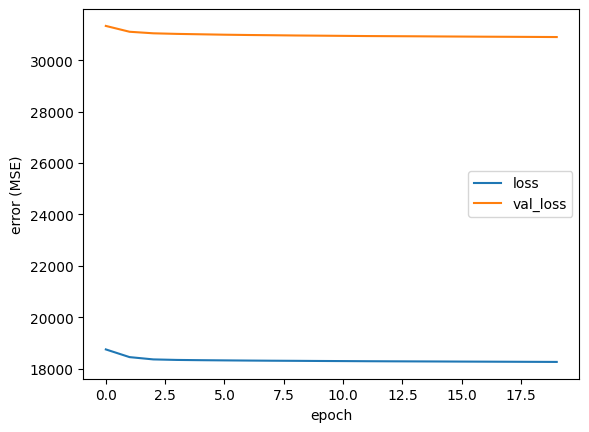

In [9]:
eval_results = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error (MAE): ${eval_results[1]:.2f}")

# plot history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('error (MSE)')
plt.legend()
plt.show()

In [10]:
# save model locally
model.export('taxi_fare_model')

INFO:tensorflow:Assets written to: taxi_fare_model\assets


INFO:tensorflow:Assets written to: taxi_fare_model\assets


Saved artifact at 'taxi_fare_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2139735673744: TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
  2139735673168: TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
  2139735672976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139735674512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139735674320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139735673360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139735672784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139735675280: TensorSpec(shape=(), dtype=tf.resource, name=None)
